In [1]:
%pip install torch torchvision pandas numpy matplotlib pillow seaborn scikit-learn opencv-python
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [67]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
import seaborn as sns
from skimage import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

**Dataset paths and loading parsed XML annotations (df)**

In [68]:
dataset_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/newDataset_images'
annotations_pth = 'C:/MAMP/htdocs/2025_GP_27/model1/annotations'
image_files = sorted([f for f in os.listdir(dataset_pth) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
xml_files = sorted([f for f in os.listdir(annotations_pth) if f.lower().endswith('.xml')])
%store -r df

In [69]:
%pip install nbformat


Note: you may need to restart the kernel to use updated packages.


**Dataset quality and consistency analysis**

we run several checks to understand and validate the dataset

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Stored 'df' (DataFrame)
Created DataFrame with 3231 samples
Checking for inconsistencies, missing files, and data issues...

CHECKING IMAGE-XML CORRESPONDENCE:
   Checked 0/3231 files...
   Checked 500/3231 files...
   Checked 1000/3231 files...
   Checked 1500/3231 files...
   Checked 2000/3231 files...
   Checked 2500/3231 files...
   Checked 3000/3231 files...
Finished checking 3231 xml files.
Missing images: 316, XML parse errors: 0, issues_found: 316
The missing images are: [('normal_pressure_1.xml', '136.png'), ('normal_pressure_10.xml', '145.png'), ('normal_pressure_100.xml', '235.png'), ('normal_pressure_101.xml', '236.png'), ('normal_pressure_102.xml', '237.png'), ('normal_pressure_103.xml', '238.png'), ('normal_pressure_104.xml', '239.png'), ('normal_pressure_105.xml', '240.png'), ('normal_pressure_106.xml', '241.png'), ('normal_pressure_107.xml'

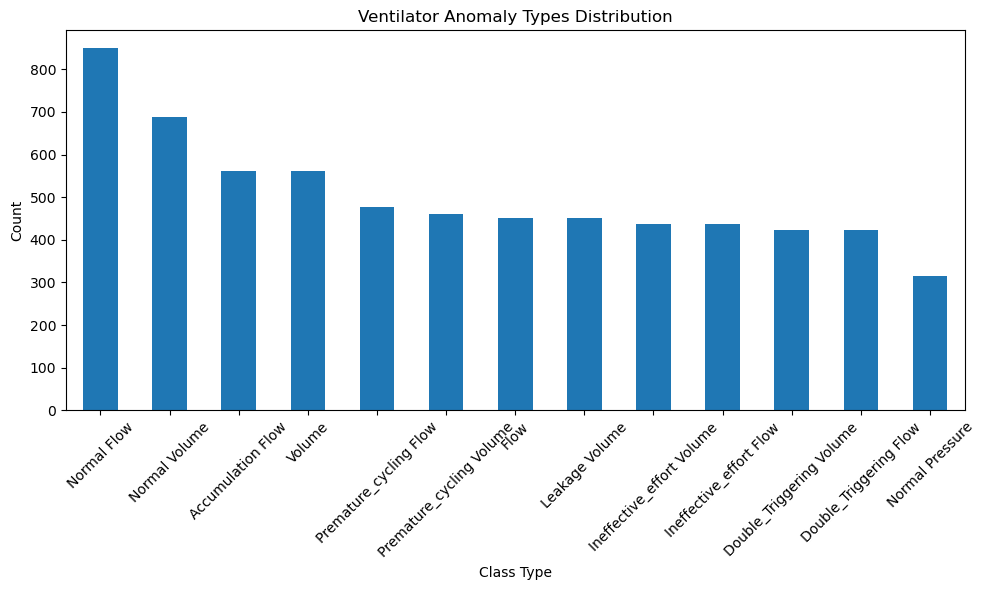

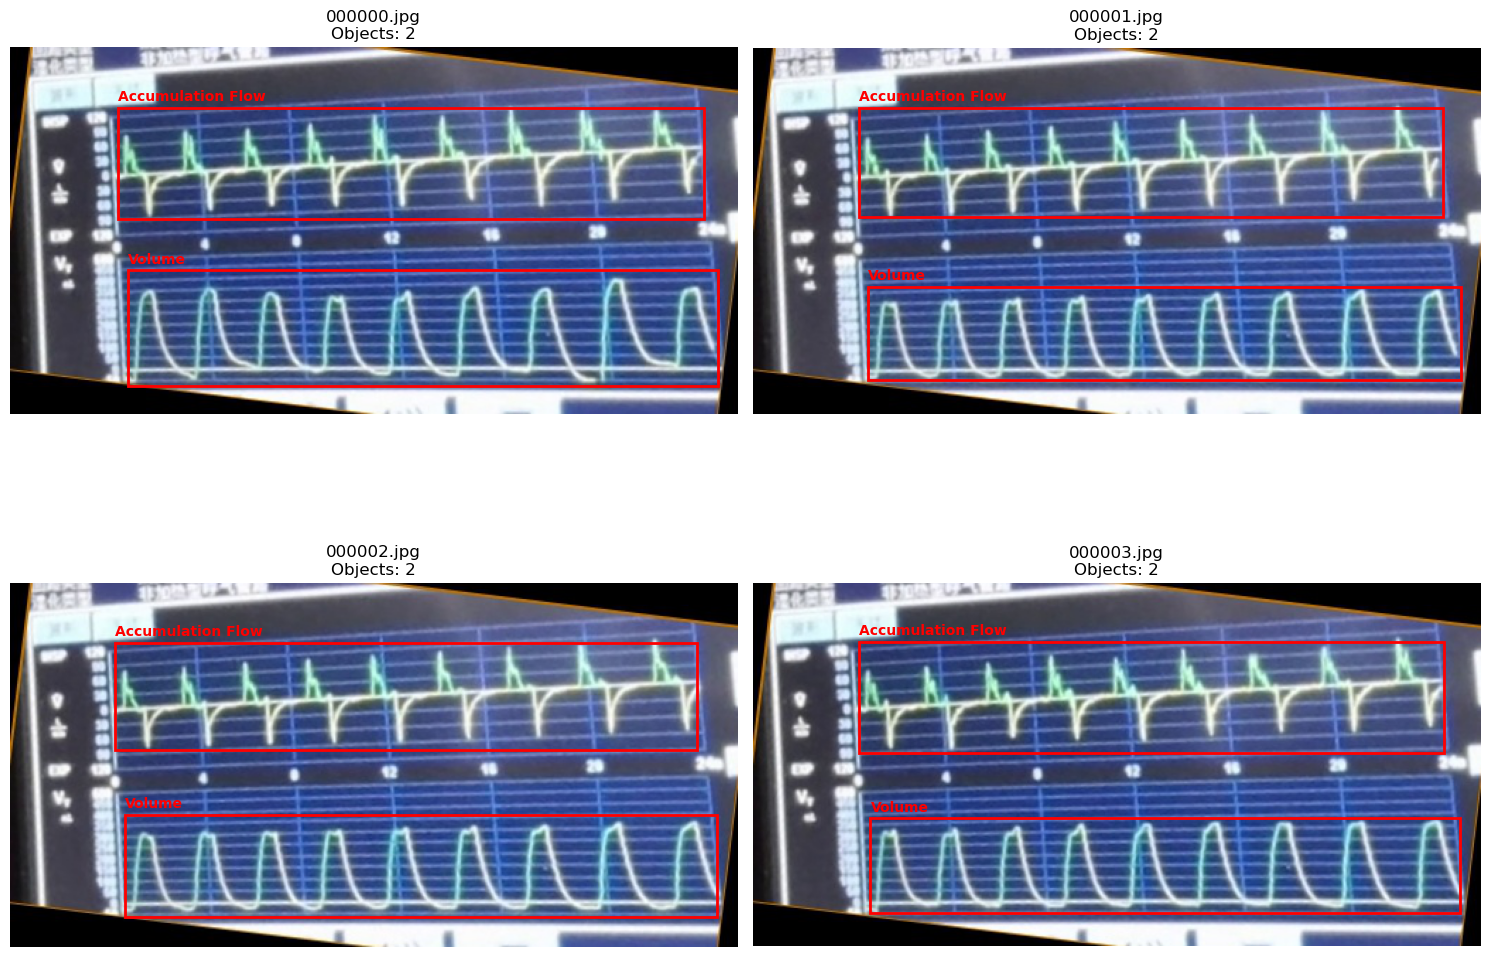

=== TESTING DIFFERENT BACKGROUND REGIONS ===
top_left: STD = 64.06, Mean = 191.16
Region: top_left, Noise STD: 64.05723889897222
top_right: STD = 55.87, Mean = 72.50
Region: top_right, Noise STD: 55.874706257482906
bottom_left: STD = 53.49, Mean = 54.75
Region: bottom_left, Noise STD: 53.48695243365432
bottom_right: STD = 57.67, Mean = 124.85
Region: bottom_right, Noise STD: 57.6729907197468
center_top: STD = 23.02, Mean = 84.30
Region: center_top, Noise STD: 23.024968707904907

=== NOISE ASSESSMENT ===
000000.jpg: Very Noisy (STD: 31.2) - Denoise: True
000000_Accumulation_Flow_0.jpg: Very Noisy (STD: 32.1) - Denoise: True
000000_Volume_1.jpg: Very Noisy (STD: 34.3) - Denoise: True
000001.jpg: Very Noisy (STD: 30.9) - Denoise: True
000001_Accumulation_Flow_0.jpg: Very Noisy (STD: 31.2) - Denoise: True
000001_Volume_1.jpg: Very Noisy (STD: 33.8) - Denoise: True
000002.jpg: Very Noisy (STD: 30.9) - Denoise: True
000002_Accumulation_Flow_0.jpg: Very Noisy (STD: 31.2) - Denoise: True
00000

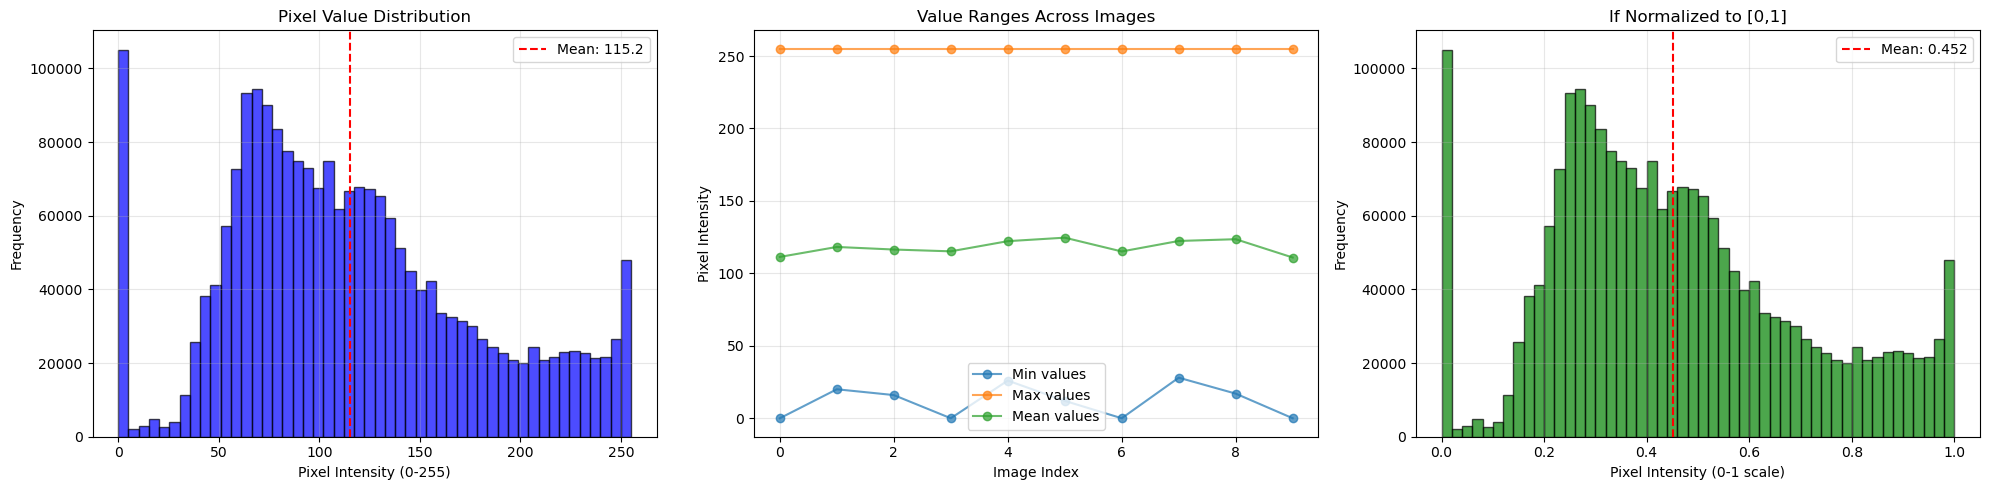

=== NORMALIZATION STATUS ANALYSIS ===
Data appears to be on scale: 
  [0, 255] scale: True
  [0, 1] scale: False
  [-1, 1] scale: False
CONCLUSION: Data is in standard 0-255 range
   Normalization to [0,1] is REQUIRED for ML models
Analyzing image quality for sample images...

Image Quality Summary:
                         filename        size  mean_intensity  contrast  \
0                      000000.jpg  (514, 259)      105.300340       255   
1  000000_Accumulation_Flow_0.jpg   (414, 79)      112.011191       205   
2             000000_Volume_1.jpg   (417, 82)      107.470170       199   
3                      000001.jpg  (515, 259)      108.953436       255   
4  000001_Accumulation_Flow_0.jpg   (413, 77)      115.675042       201   
5             000001_Volume_1.jpg   (420, 66)      116.353391       199   
6                      000002.jpg  (515, 258)      108.875728       255   
7  000002_Accumulation_Flow_0.jpg   (412, 76)      115.863120       202   
8             000002_Vol

In [70]:
%run imageRead.ipynb

In [71]:
#Ensure df is loaded
print("DataFrame loaded with", len(df), "rows")

DataFrame loaded with 3231 rows


 **Cleaning missing images and building full image paths**


In [72]:
df['image_name'] = df['image_name'].astype(str)
df['image_name'] = df['image_name'].str.replace('\t', '', regex=False)
df['image_name'] = df['image_name'].str.strip()

df['image_path'] = df['image_name'].apply(lambda x: os.path.join(dataset_pth, x))

print("Sample image names and paths:")
print(df[['image_name', 'image_path']].head())

# Find annotations with missing image files
missing = df[~df['image_path'].apply(os.path.exists)]
print("Number of missing image files:", len(missing))

if len(missing) > 0:
    print("Example of missing files:")
    print(missing[['image_name', 'image_path']].head())

df = df[df['image_path'].apply(os.path.exists)].reset_index(drop=True)
print("After removing missing images, total rows:", len(df))

missing_after = df[~df['image_path'].apply(os.path.exists)]
print("After cleaning, missing files:", len(missing_after))


Sample image names and paths:
   image_name                                         image_path
0  000000.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
1  000001.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2  000002.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
3  000003.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
4  000004.jpg  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
Number of missing image files: 316
Example of missing files:
     image_name                                         image_path
2915    136.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2916    145.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2917    235.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2918    236.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
2919    237.png  C:/MAMP/htdocs/2025_GP_27/model1/newDataset_im...
After removing missing images, total rows: 2915
After cleaning, missing files: 0


**Denoise Transform using Edge preserving**

In [73]:
class DenoiseTransform:
    """
    Apply gentle, edge-preserving denoising using OpenCV fastNlMeansDenoisingColored.
    Input : PIL Image (RGB)
    Output: PIL Image (RGB) after noise reduction
    """
    def __call__(self, img_pil):
        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)

        # OpenCV expects BGR, so convert if needed
        img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        # Apply gentle denoising (small h values to avoid over-smoothing)
        denoised_bgr = cv2.fastNlMeansDenoisingColored(
            img_bgr,
            None,
            h=6,          # luminance filter strength
            hColor=6,     # color filter strength
            templateWindowSize=7,
            searchWindowSize=21
        )

        # Back to RGB
        denoised_rgb = cv2.cvtColor(denoised_bgr, cv2.COLOR_BGR2RGB)

        # Convert back to PIL
        return Image.fromarray(denoised_rgb)

Image Index 0: 000000.jpg


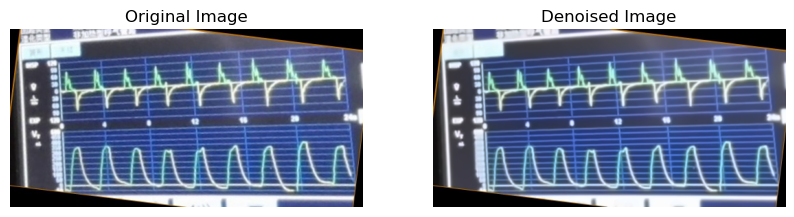

Image Index 3: 000001.jpg


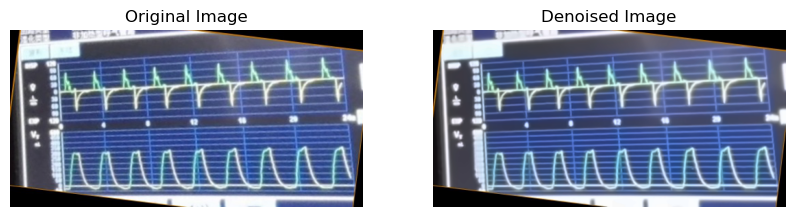

Image Index 6: 000002.jpg


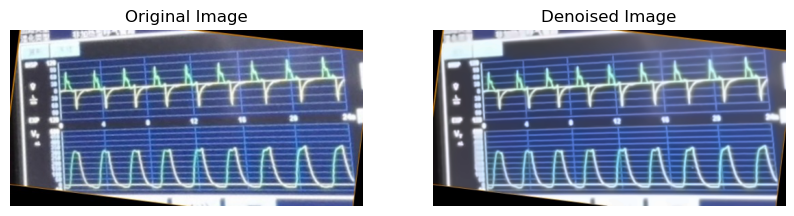

Image Index 9: 000003.jpg


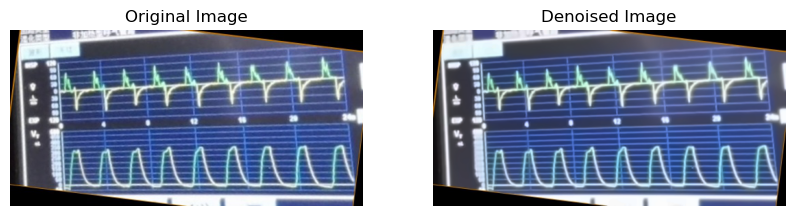

In [74]:

indices = [0, 3, 6, 9]

for idx in indices:
    if idx >= len(image_files):
        print(f"Index {idx} خارج نطاق الصور!")
        continue
    
    image_file = image_files[idx]
    img_path = os.path.join(dataset_pth, image_file)

 
    row = df[df['image_name'] == image_file].iloc[0]

   
    denoise_transform = DenoiseTransform()

    original_img = Image.open(img_path).convert('RGB')
    denoised_img = denoise_transform(original_img)

    print(f"Image Index {idx}: {row['image_name']}")

    plt.figure(figsize=(10, 4))


    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.axis('off')


    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(denoised_img)
    plt.axis('off')

    plt.show()


**Pixel value range and normalization check**

In [75]:
print("=== NORMALIZATION PIXELS [0,1] ===")

for image_file in image_files[:2]:
    img_path = os.path.join(dataset_pth, image_file)
    image_pil = Image.open(img_path)
    image_array = np.array(image_pil)
 
    # normalization to [0,1] 
    normalized = image_array.astype(np.float32) / 255.0
    print(f"{image_file}:")
    print(f"   Original range: [{image_array.min()}, {image_array.max()}]")
    print(f"   After /255:     [{normalized.min():.3f}, {normalized.max():.3f}]")    
    print(f"   First pixel values:")
    print(f"   Original: {image_array[0,0,:]}")
    print(f"   After /255: {normalized[0,0,:]}")
    print()


=== NORMALIZATION PIXELS [0,1] ===
000000.jpg:
   Original range: [0, 255]
   After /255:     [0.000, 1.000]
   First pixel values:
   Original: [1 0 4]
   After /255: [0.00392157 0.         0.01568628]

000000_Accumulation_Flow_0.jpg:
   Original range: [22, 255]
   After /255:     [0.086, 1.000]
   First pixel values:
   Original: [ 91 110 142]
   After /255: [0.35686275 0.43137255 0.5568628 ]



 **Label extraction and encoding**



In [76]:
import os
import pandas as pd
from PIL import Image

SAVE_DIR = "newDataset_images"
os.makedirs(SAVE_DIR, exist_ok=True)

def crop_and_save(df):
    rows_data = []

    for idx, row in df.iterrows():
        img = Image.open(row['image_path'])

        for obj_idx, obj in enumerate(row["objects"]):
            bbox = obj["bbox"]
            class_name = obj["class"].strip()

            # قص الصورة
            cropped = img.crop((bbox["xmin"], bbox["ymin"], bbox["xmax"], bbox["ymax"]))

            # اسم جديد
            new_name = f"{row['image_name'].split('.')[0]}_{class_name.replace(' ', '_')}_{obj_idx}.jpg"
            save_path = os.path.join(SAVE_DIR, new_name)

            cropped.save(save_path)

            # حفظ البيانات
            rows_data.append([new_name, class_name])

    cropped_df = pd.DataFrame(rows_data, columns=["image_name", "label_name"])
    return cropped_df

cropped_df = crop_and_save(df)


In [77]:
rename_map = {
    "Volume": "Accumulation Volume",
    "Flow": "Leakage Flow"
}

cropped_df["label_name"] = cropped_df["label_name"].replace(rename_map)


In [78]:
CLASSES = sorted(cropped_df["label_name"].unique())
NUM_CLASSES = len(CLASSES)

label_to_idx = {lab: i for i, lab in enumerate(CLASSES)}
idx_to_label = {i: lab for lab, i in label_to_idx.items()}

cropped_df["label_id"] = cropped_df["label_name"].map(label_to_idx)

print("Number of classes:", NUM_CLASSES)
for i, name in enumerate(CLASSES):
    print(i, "→", name)

print("\nCounts per class:")
print(cropped_df["label_id"].value_counts().sort_index())


Number of classes: 12
0 → Accumulation Flow
1 → Accumulation Volume
2 → Double_Triggering Flow
3 → Double_Triggering Volume
4 → Ineffective_effort Flow
5 → Ineffective_effort Volume
6 → Leakage Flow
7 → Leakage Volume
8 → Normal Flow
9 → Normal Volume
10 → Premature_cycling Flow
11 → Premature_cycling Volume

Counts per class:
label_id
0     562
1     562
2     422
3     424
4     438
5     438
6     452
7     452
8     564
9     564
10    476
11    460
Name: count, dtype: int64


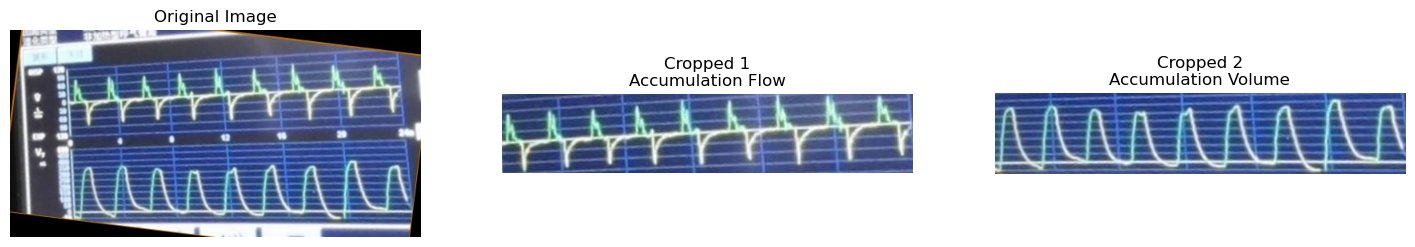

In [79]:
import matplotlib.pyplot as plt

def show_before_after(df, cropped_df, index=0):
    original_path = df.iloc[index]["image_path"]
    original_img = Image.open(original_path)
    base_name = df.iloc[index]["image_name"].split(".")[0]

    samples = cropped_df[cropped_df["image_name"].str.contains(base_name)]

    fig, ax = plt.subplots(1, len(samples)+1, figsize=(6*(len(samples)+1), 6))

    ax[0].imshow(original_img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    for i, (_, row) in enumerate(samples.iterrows(), start=1):
        crop_img = Image.open(os.path.join(SAVE_DIR, row["image_name"]))
        ax[i].imshow(crop_img)
        ax[i].set_title(f"Cropped {i}\n{row['label_name']}")
        ax[i].axis("off")

    plt.show()

show_before_after(df, cropped_df, index=0)


In [80]:
print(df.columns)

Index(['image_name', 'image_path', 'xml_path', 'width', 'height',
       'num_objects', 'objects'],
      dtype='object')


In [81]:
cropped_df.head(6)

image_name           label_name  label_id
0  000000_Accumulation_Flow_0.jpg    Accumulation Flow         0
1             000000_Volume_1.jpg  Accumulation Volume         1
2  000001_Accumulation_Flow_0.jpg    Accumulation Flow         0
3             000001_Volume_1.jpg  Accumulation Volume         1
4  000002_Accumulation_Flow_0.jpg    Accumulation Flow         0
5             000002_Volume_1.jpg  Accumulation Volume         1

 **Train / Validation / Test split**


In [82]:
from sklearn.model_selection import train_test_split

print("Total samples after cropping & labeling:", len(cropped_df))

train_df, temp_df = train_test_split(
    cropped_df,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=cropped_df['label_id']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True,
    stratify=temp_df['label_id']
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("\nTrain label counts:\n", train_df['label_id'].value_counts().sort_index())
print("\nVal label counts:\n",   val_df['label_id'].value_counts().sort_index())
print("\nTest label counts:\n",  test_df['label_id'].value_counts().sort_index())


Total samples after cropping & labeling: 5814
Train: 4069 Val: 872 Test: 873

Train label counts:
 label_id
0     393
1     393
2     295
3     297
4     307
5     307
6     316
7     316
8     395
9     395
10    333
11    322
Name: count, dtype: int64

Val label counts:
 label_id
0     84
1     84
2     64
3     64
4     66
5     66
6     68
7     68
8     84
9     84
10    71
11    69
Name: count, dtype: int64

Test label counts:
 label_id
0     85
1     85
2     63
3     63
4     65
5     65
6     68
7     68
8     85
9     85
10    72
11    69
Name: count, dtype: int64


 **Image transforms (augmentations & normalization)**


In [83]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.RandomRotation(3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    DenoiseTransform(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ),
])


**Custom TanafsDataset class**

In [84]:
class TanafsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join("newDataset_images", row['image_name'])
        label    = row['label_id']

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [85]:
BATCH_SIZE = 16

train_dataset = TanafsDataset(train_df, transform=train_transform)
val_dataset   = TanafsDataset(val_df,   transform=val_test_transform)
test_dataset  = TanafsDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5])


Images shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
First 5 labels: tensor([5, 5, 4, 8, 3])


 **Visual sanity check**

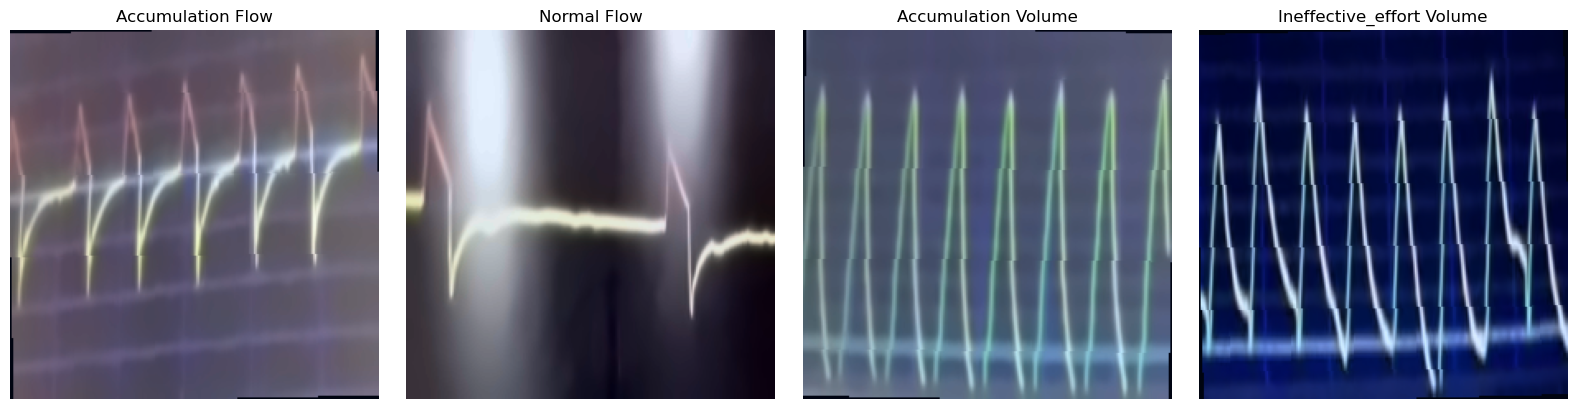

In [86]:
def show_batch(images, labels, classes, n=4):
    imgs = images[:n].clone().detach()
    imgs = imgs.permute(0, 2, 3, 1)  # [B,H,W,3]

    plt.figure(figsize=(4 * n, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = imgs[i].numpy()
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)
        ax.imshow(img)
        cls_id = int(labels[i].item())
        cls_name = classes[cls_id]
        ax.set_title(cls_name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, CLASSES, n=4)
